Modelo de Casos Confirmados

      fun: 105.11179921065403
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.27874549e+06, -3.02103643e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 423
      nit: 15
   status: 0
  success: True
        x: array([1.26257036e-05, 1.02778533e-02])
country=Ecuador, beta=0.00001263, gamma=0.01027785, r_0:0.00122844


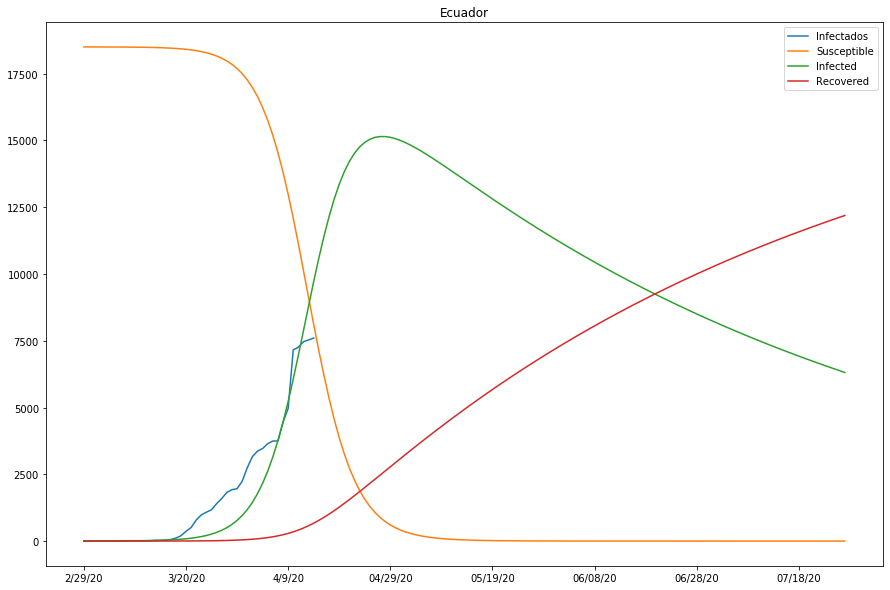

In [4]:
import numpy as np
import pandas as pd
from csv import reader
from csv import writer
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import argparse
import sys
import json
import ssl
import urllib.request
from easydict import EasyDict as easydict



def parse_arguments():
    args = easydict({
        "countries":"Ecuador",
        "download_data":False,
        "start_date":"2/29/20",
        "predict_range":150,
        "s_0":18500,
        "i_0":1,
        "r_0":0
    })

    country_list = ["Ecuador"]
    return (country_list, args.download_data, args.start_date, args.predict_range, args.s_0, args.i_0, args.r_0)


def sumCases_province(input_file, output_file):
    with open(input_file, "r") as read_obj, open(output_file,'w',newline='') as write_obj:
        csv_reader = reader(read_obj)
        csv_writer = writer(write_obj)
               
        lines=[]
        for line in csv_reader:
            lines.append(line)    

        i=0
        ix=0
        for i in range(0,len(lines[:])-1):
            if lines[i][1]==lines[i+1][1]:
                if ix==0:
                    ix=i
                lines[ix][4:] = np.asfarray(lines[ix][4:],float)+np.asfarray(lines[i+1][4:] ,float)
            else:
                if not ix==0:
                    lines[ix][0]=""
                    csv_writer.writerow(lines[ix])
                    ix=0
                else:
                    csv_writer.writerow(lines[i])
            i+=1    


def download_data(url_dictionary):
    #Lets download the files
    for url_title in url_dictionary.keys():
        urllib.request.urlretrieve(url_dictionary[url_title], "./data/" + url_title)


def load_json(json_file_str):
    # Loads  JSON into a dictionary or quits the program if it cannot.
    try:
        with open(json_file_str, "r") as json_file:
            json_variable = json.load(json_file)
            return json_variable
    except Exception:
        sys.exit("Cannot open JSON file: " + json_file_str)


class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0


    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_dead(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country))
        
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infectados': extended_actual,'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}confirmed.png")


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2


def main():

    countries, download, startdate, predict_range , s_0, i_0, r_0 = parse_arguments()

    if download:
        data_d = load_json("./data_url.json")
        download_data(data_d)

    #sumCases_province('data/time_series_19-covid-Confirmed.csv', 'data/time_series_19-covid-Confirmed-country.csv')
    #sumCases_province('data/time_series_19-covid-Recovered.csv', 'data/time_series_19-covid-Recovered-country.csv')
    #sumCases_province('data/time_series_19-covid-Deaths.csv', 'data/time_series_19-covid-Deaths-country.csv')

    for country in countries:
        learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        #try:
        learner.train()
        #except BaseException:
        #    print('WARNING: Problem processing ' + str(country) +
        #        '. Be sure it exists in the data exactly as you entry it.' +
        #        ' Also check date format if you passed it as parameter.')
           

if __name__ == '__main__':
    main()

<img src="https://github.com/wilo96/Simulacion/blob/master/Ecuadorconfirmed.png">

Modelo de Casos Confirmados y Recuperados

      fun: 108.69489704184419
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.16270534e+05, 4.11444589e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 10
   status: 0
  success: True
        x: array([1.25267600e-05, 1.10707923e-02])
country=Ecuador, beta=0.00001253, gamma=0.01107079, r_0:0.00113151


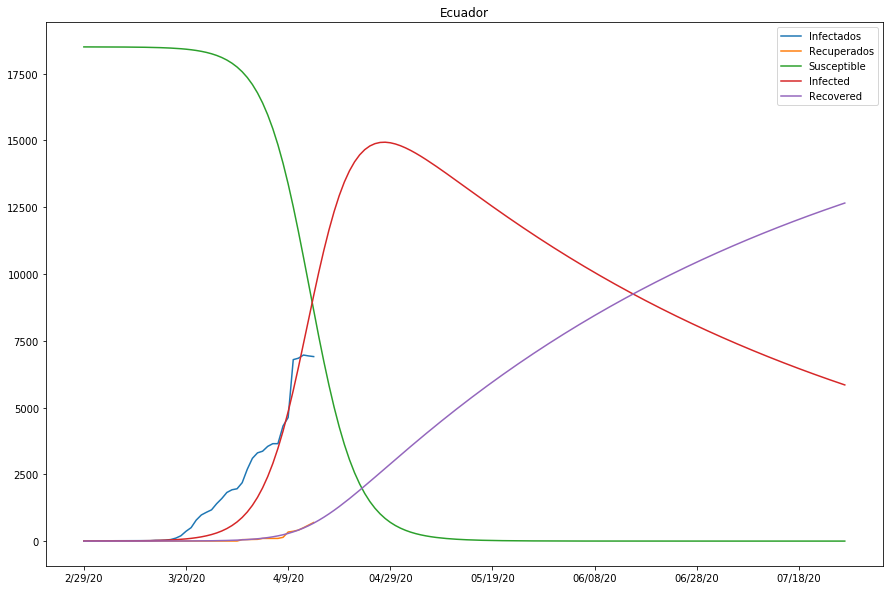

In [5]:
#!/usr/bin/python
import numpy as np
import pandas as pd
from csv import reader
from csv import writer
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import argparse
import sys
import json
import ssl
import urllib.request
from easydict import EasyDict as easydict



def parse_arguments():
    args = easydict({
        "countries":"Ecuador",
        "download_data":False,
        "start_date":"2/29/20",
        "predict_range":150,
        "s_0":18500,
        "i_0":1,
        "r_0":0
    })

    country_list = ["Ecuador"]
    return (country_list, args.download_data, args.start_date, args.predict_range, args.s_0, args.i_0, args.r_0)


def sumCases_province(input_file, output_file):
    with open(input_file, "r") as read_obj, open(output_file,'w',newline='') as write_obj:
        csv_reader = reader(read_obj)
        csv_writer = writer(write_obj)
               
        lines=[]
        for line in csv_reader:
            lines.append(line)    

        i=0
        ix=0
        for i in range(0,len(lines[:])-1):
            if lines[i][1]==lines[i+1][1]:
                if ix==0:
                    ix=i
                lines[ix][4:] = np.asfarray(lines[ix][4:],float)+np.asfarray(lines[i+1][4:] ,float)
            else:
                if not ix==0:
                    lines[ix][0]=""
                    csv_writer.writerow(lines[ix])
                    ix=0
                else:
                    csv_writer.writerow(lines[i])
            i+=1    


def download_data(url_dictionary):
    #Lets download the files
    for url_title in url_dictionary.keys():
        urllib.request.urlretrieve(url_dictionary[url_title], "./data/" + url_title)


def load_json(json_file_str):
    # Loads  JSON into a dictionary or quits the program if it cannot.
    try:
        with open(json_file_str, "r") as json_file:
            json_variable = json.load(json_file)
            return json_variable
    except Exception:
        sys.exit("Cannot open JSON file: " + json_file_str)


class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0


    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_dead(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country) - recovered)
        
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infectados': extended_actual, 'Recuperados': extended_recovered, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}reco.png")


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2


def main():

    countries, download, startdate, predict_range , s_0, i_0, r_0 = parse_arguments()

    if download:
        data_d = load_json("./data_url.json")
        download_data(data_d)

    #sumCases_province('data/time_series_19-covid-Confirmed.csv', 'data/time_series_19-covid-Confirmed-country.csv')
    #sumCases_province('data/time_series_19-covid-Recovered.csv', 'data/time_series_19-covid-Recovered-country.csv')
    #sumCases_province('data/time_series_19-covid-Deaths.csv', 'data/time_series_19-covid-Deaths-country.csv')

    for country in countries:
        learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        #try:
        learner.train()
        #except BaseException:
        #    print('WARNING: Problem processing ' + str(country) +
        #        '. Be sure it exists in the data exactly as you entry it.' +
        #        ' Also check date format if you passed it as parameter.')
           

if __name__ == '__main__':
    main()

Calculando la Incidencia y Prevalencia

In [30]:
poblacion = 18500

df3 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
country_df3 = df3[df3['Country/Region'] == "Ecuador"]
confirmados = country_df3.iloc[0].loc["2/29/20":]

ultimo=confirmados[len(confirmados)-1]
anteultimo=confirmados[len(confirmados)-2]
nuevoscasos=ultimo-anteultimo
riesgo= poblacion - ultimo
incidencia = (nuevoscasos/riesgo)*pow(10, 3)
print('Incidencia: ',incidencia)
prevalencia = (ultimo/poblacion)*pow(10, 3) 
print('Prevalencia: ', prevalencia)




Incidencia:  6.790859869688905
Prevalencia:  410.97297297297297


    Análisis:
En el código pude notar que cuando aumentaba la poblacion se demoraba mucho mas en terminar de predecir el beta y gamma, donde me devolvia valores muy bajos.
Cuando el código se lo ejecutó de manera local me devolvió imagenes diferentes tanto cuando se trataba solo de Confirmados y otra cuando se trataba de Confirmados y Recuperados, pero en este cuaderno devuleve la misma imagen, pero dentro de este repositorio esta agregada la otra imagen que me devolció.
Enlace: https://github.com/wilo96/Simulacion/blob/master/Ecuadorconfirmed.png

    Conclusiones: 
El modelo SIR nos ayuda a predecir de mejor manera los avances del virus en nuestro país dándonos una idea más clara de la poblacion que esta en riesgo, los recuperados y los muertos utilizando los resultados obtenidos de nuestro modelo exponencial anterior realizado.
La incidencia y prevalencia nos aporta mucho ya que podemos determinar el grado que puede avanzar el contagio y un individuo puede infectarse en un periodo o momento dado.

    Opinion:
En mi opinion personal, existio un incremento masivo en los infectados dado que las industrias y peronas en si no quieren permanecer mas en sus casas y quieren salir a trabajar y desempeñar sus actividades, por lo cual el govierno deberia tomar medidas para que no afecten a la población ni a la economía del país.